In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [ ]:
## Link to download the dataset => https://www.kaggle.com/c/titanic/data

In [ ]:
titanic_data = pd.read_csv('data/train.csv')

In [ ]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


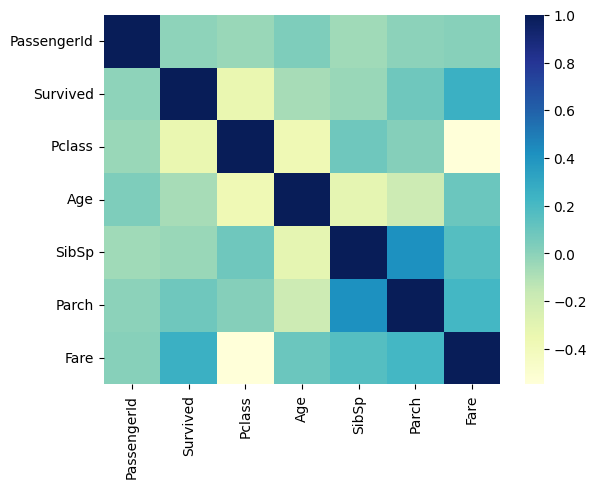

In [ ]:
sns.heatmap(titanic_data.corr(numeric_only=True), cmap="YlGnBu")
plt.show()

### What this code does:
- It splits the Titanic dataset into a training set (80%) and a test set (20%).

- It uses stratified sampling, which means the train and test sets keep the same balance of important columns (`Survived`, `Pclass`, `Sex`) as the full dataset.

- This helps prevent bias and ensures the model trains and tests on similar distributions of data.

### Key points:
- `StratifiedShuffleSplit` is used to keep the class distribution balanced.

- `n_splits=1`: Only one train/test split is needed.

- The for loop is required because `.split(...)` returns a generator, even with just one split.

- `.loc[train_indices]` and `.loc[test_indices]` are used to get the actual data rows by their index.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived","Pclass", "Sex"]]):
  strat_train_set = titanic_data.loc[train_indices]
  strat_test_set = titanic_data.loc[test_indices]

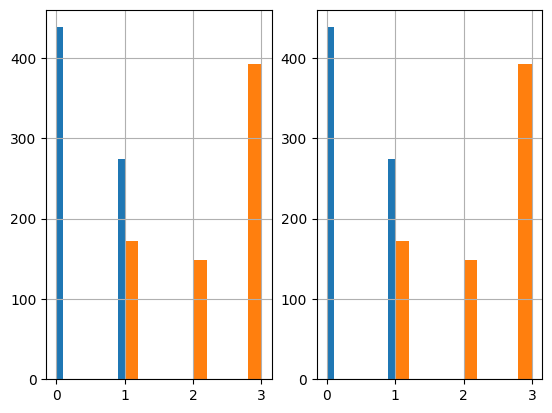

In [ ]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.subplot(1,2,2)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

plt.show()

##Result: we can see that distribution of 'Survived' and 'Pclass' attributes are the same in the two sets, thanks to StratifiedShuffleSplit!
# Blue bars = Survived
# Orange bars = Pclass

# Pipeline:
### 1. Age Imputer:
Fills missing values in the Age column using the average (mean).
### 2. Feature Encoder:
Converts categorical columns like `'Sex'` and `'Embarked'` into numbers using one-hot encoding (turns them into 0s and 1s).
### 3. Feature Dropper:
Removes columns we don’t need, such as `'Name'`, `'Ticket'`, `'Cabin'`, and others that are not helpful for training.

## Age Imputer:

### What this code does:
- It defines a custom transformer called `AgeImputer` that fills missing values in the `Age` column.

- Missing `Age` values are replaced with the mean age using `SimpleImputer(strategy='mean')`.


### How it works:
- `fit(self, X, y=None):` This method is required, but it doesn't need to learn anything, so it just returns `self`.

- `transform(self, X)`:

  - Applies the `SimpleImputer` to the `"Age"` column.

  - Fills in missing values with the average age.

  - Returns the updated DataFrame.


  📝 Note: `X[['Age']]` uses double brackets because `SimpleImputer` expects a 2D input (like a table with one column), not a single column (1D).

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    imputer = SimpleImputer(strategy='mean')
    X['Age'] = imputer.fit_transform(X[['Age']])
    return X

## Feature Encoder

### What this custom transformer does:
- It allows automatic encoding of `Embarked` and `Sex` categorical columns in a clean, reusable way during preprocessing.

- It uses `OneHotEncoder` to convert each category into its own column filled with `1`s and `0`s.

- The `.T` (transpose) is used to loop over each encoded column and assign it back to the DataFrame by its corresponding name.


### How OneHotEncoder works:
- Turns a column like:

```
['C', 'Q', 'S', 'C', None]
```
Into:
```
[[1, 0, 0, 0],   # C
 [0, 1, 0, 0],   # Q
 [0, 0, 1, 0],   # S
 [1, 0, 0, 0],   # C
 [0, 0, 0, 1]]   # missing
 ```
- Then assigns each column to the DataFrame with meaningful names like `'C'`, `'Q'`, `'S'`, `'missing'`.


- Why use `.T` (transpose)
- One-hot encoding returns an array with rows = samples, columns = categories.

- Transposing it flips the shape to rows = categories, making it easier to loop over and assign each one back to the DataFrame.


### ✅ Final Output:
- Original columns (`Sex`, `Embarked`) are preserved.

New binary columns (`Female`, `Male`, `C`, `Q`, `S`, `missing`) are added.




In [ ]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    encoder = OneHotEncoder()
    matrix = encoder.fit_transform(X[['Embarked']]).toarray()

    column_names = ["C", "S", "Q", "N"]

    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

      matrix = encoder.fit_transform(X[['Sex']]).toarray()

      column_names = ["Female", "Male"]

      for i in range(len(matrix.T)):
        X[column_names[i]] = matrix.T[i]

      return X

## Feature Dropper

### Purpose:
- This custom transformer is used to drop irrelevant or unneeded columns from the dataset during preprocessing.

- It simplifies the pipeline by isolating column removal into a reusable class.

### How it works:
- In `fit`: Does nothing and just returns `self`, as there's no need to learn anything from the data.

- In transform:

  - Drops the columns:

    - `'Embarked'` → already encoded elsewhere

    - `'Name'`, `'Ticket'`, `'Cabin'` → text columns not useful for modeling

    - `'Sex'` → already one-hot encoded

    - `'N'` → possibly a helper column, no longer needed

  - Uses `errors='ignore'` to prevent errors if a column is missing.


### Why this is useful:
- Makes your preprocessing cleaner and modular.

- Prevents accidental use of raw categorical/text data that could degrade model performance.

### ✅ Result:
- Only the numeric and encoded features remain in the dataset.

- The data is cleaned and ready for model training.



In [ ]:
class FeatureDropper(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

### What's happening here?
This code creates a **pipeline** in scikit-learn. A pipeline is a way to **chain multiple preprocessing steps together** so they run one after the other automatically.

It’s like a **conveyor belt**:
Your raw data goes in at the beginning, and by the end, it’s clean and ready for machine learning.


### Steps in the Pipeline:
1. `AgeImputer()`
Fills missing values in the `Age` column using the average (mean).

2. `FeatureEncoder()`
Converts categorical columns like `'Sex'` and `'Embarked'` into numbers using one-hot encoding (turns them into 0s and 1s).

3. `FeatureDropper()`
Removes columns we don’t need, such as `'Name'`, `'Ticket'`, `'Cabin'`, and others that are not helpful for training.


### Why use a pipeline?
- Keeps your code clean and organized

- Makes sure the same transformations are applied during training and testing

- Easy to combine with a model like `LogisticRegression` or `RandomForest` in a single step

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),
                     ("featureencoder", FeatureEncoder()),
                     ("featuredropper", FeatureDropper())])

In [ ]:
strat_train_set = pipeline.fit_transform(strat_train_set)

In [ ]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,Female,Male
641,642,1,1,24.000000,0,0,69.3000,1.0,1.0,0.0
668,669,0,3,43.000000,0,0,8.0500,0.0,0.0,1.0
648,649,0,3,29.832014,0,0,7.5500,0.0,0.0,1.0
74,75,1,3,32.000000,0,0,56.4958,0.0,0.0,1.0
40,41,0,3,40.000000,1,0,9.4750,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
797,798,1,3,31.000000,0,0,8.6833,0.0,1.0,0.0
257,258,1,1,30.000000,0,0,86.5000,0.0,1.0,0.0
656,657,0,3,29.832014,0,0,7.8958,0.0,0.0,1.0
108,109,0,3,38.000000,0,0,7.8958,0.0,0.0,1.0


In [ ]:
strat_train_set.info()
##Result: there is no null values anymore

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 641 to 157
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   Female       712 non-null    float64
 9   Male         712 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 61.2 KB


## Scaling:
`StandardScaler` is used to **normalize features**, so they all have:

 -Mean = 0

- Standard deviation = 1


`X_data = scaler.fit_transform(X)`:
- You apply scaling to your features:

  - `.fit(X)` calculates the mean and std for each column.

  - `.transform(X)` scales each column accordingly.

- X_data will now have standardized values.

In [ ]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis=1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [ ]:
X_data

array([[ 7.49543835e-01, -1.56828591e+00, -4.54865583e-01, ...,
         2.15656988e+00,  1.35941164e+00, -1.35941164e+00],
       [ 8.54201234e-01,  8.27893418e-01,  1.02703173e+00, ...,
        -4.63699326e-01, -7.35612358e-01,  7.35612358e-01],
       [ 7.76677235e-01,  8.27893418e-01, -2.77092466e-16, ...,
        -4.63699326e-01, -7.35612358e-01,  7.35612358e-01],
       ...,
       [ 8.07686835e-01,  8.27893418e-01, -2.77092466e-16, ...,
        -4.63699326e-01, -7.35612358e-01,  7.35612358e-01],
       [-1.31647074e+00,  8.27893418e-01,  6.37058754e-01, ...,
        -4.63699326e-01, -7.35612358e-01,  7.35612358e-01],
       [-1.12653695e+00,  8.27893418e-01,  1.31019897e-02, ...,
        -4.63699326e-01, -7.35612358e-01,  7.35612358e-01]])

In [ ]:
y_data

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,

# Train the model on train splitted data:
- A **Random Forest** is an algorithm that builds many decision trees and then combines them to make more accurate predictions.
- It’s good for classification tasks, like predicting if a passenger survived or not.<br>
<br>

- `GridSearchCV` helps you **automatically test different combinations of parameters** for your model and pick the best ones.
- It does this by **training multiple models** and comparing their performance.
<br></br>
<br></br>
```python
param_grid = [
    {
      "n_estimators": [10, 100, 200, 500],         # number of trees in the forest
      "max_depth": [None, 5, 10],                  # max depth of each tree
      "min_samples_split": [2, 3, 4]               # min number of samples to split a node
    }
]
```
- This means:

  - Try models with 10, 100, 200, and 500 trees.

  - For each of those, also try 3 different max depths: unlimited (`None`), 5, and 10.

  - For each of those, try splitting nodes when there are 2, 3, or 4 samples.

In total: 4 x 3 x 3 = 36 combinations.
<br></br>
<br></br>
`grid_search = GridSearchCV(...)`
This line sets up the grid search:
```python
grid_search = GridSearchCV(
    clf,                  # The base model (Random Forest)
    param_grid,           # The dictionary of parameters to try
    cv=3,                 # Use 3-fold cross-validation
    scoring="accuracy",   # Use accuracy to judge how good the model is
    return_train_score=True  # Also return training scores
)
```
### What’s happening:

- It will train your model 36 different times (one for each combination).

- For each combination, it splits your data into 3 parts and tests the model 3 times (cross-validation).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
final_clf = grid_search.best_estimator_

In [ ]:
final_clf
#Result is the best model possible

RandomForestClassifier(max_depth=10, min_samples_split=3, n_estimators=200)

# Test the model on the test splitted data:

In [ ]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [ ]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [ ]:
final_clf.score(X_data_test, y_data_test)

0.8212290502793296

# Train the model on the whole dataset:

In [ ]:
final_data = pipeline.fit_transform(titanic_data)

In [ ]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [ ]:
prod_clf = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10,100,200,500], "max_depth": [None, 5, 10], "min_samples_split": [2,3,4]}
]

grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [ ]:
prod_final_clf = grid_search.best_estimator_

In [ ]:
prod_final_clf

RandomForestClassifier(max_depth=5, n_estimators=200)

# Test the model on the actual test dataset:

In [ ]:
titanic_test_data = pd.read_csv("data/test.csv")

In [ ]:
titanic_test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [ ]:
final_test_data

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,Female,Male
0,892,3,34.50000,0,0,7.8292,0.0,0.0,1.0
1,893,3,47.00000,1,0,7.0000,0.0,1.0,0.0
2,894,2,62.00000,0,0,9.6875,0.0,0.0,1.0
3,895,3,27.00000,0,0,8.6625,0.0,0.0,1.0
4,896,3,22.00000,1,1,12.2875,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
413,1305,3,30.27259,0,0,8.0500,0.0,0.0,1.0
414,1306,1,39.00000,0,0,108.9000,1.0,1.0,0.0
415,1307,3,38.50000,0,0,7.2500,0.0,0.0,1.0
416,1308,3,30.27259,0,0,8.0500,0.0,0.0,1.0


In [ ]:
final_test_data.info()
## as we can see here there is 1 null value in Fara column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   Female       418 non-null    float64
 8   Male         418 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 29.5 KB


In [ ]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

/tmp/ipython-input-1896703401.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_final_test = X_final_test.fillna(method="ffill")


In [ ]:
X_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         418 non-null    float64
 6   C            418 non-null    float64
 7   Female       418 non-null    float64
 8   Male         418 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 29.5 KB


In [ ]:
predictions = prod_final_clf.predict(X_data_final_test)

# Save the final predictions to CSV file:

In [ ]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("data/predictions.csv", index=False)

In [ ]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
